# light on/off classification model
1. setup
2. filter data
3. preprocessing data
4. make model & fit data
5. evaluate model & predict test
6. save model

```
- data.csv -
sensor, datetime, label
0, 2020-07-01 08:28:37, 0
35, 2020-07-01 08:38:37, 1
40, 2020-07-01 08:48:37, 1
0, 2020-07-01 08:58:37, 0
0, 2020-07-01 09:08:37, 0
0, 2020-07-01 09:18:37, 0

- data_description -
column1(sensor) - 365일 동안 10분 간격으로 조도센서(값:0~100)
column2(datetime) - datetime
column3(label) - light on: 1, light off:0
```

## 1. setup

In [2]:
from datetime import datetime as dt
import csv, os, glob
from pprint import pprint

# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
import tensorflow.keras as k
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px


# load tensorboard
%load_ext tensorboard

2021-07-30 17:43:45.749911: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
def draw_CM(label, predicted):
    cm = confusion_matrix(label, predicted)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # true : false rate
    true = 0
    false = 0
    for i, j in enumerate(label):
        if j != predicted[i] :
            false += 1
        else: true += 1

    classification_report = metrics.classification_report(label, predicted)

    multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

    return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10, 'classification_report: ', '\n', classification_report), print('='*10, 'multilabel_to_binary_matrics by class_num: ','\n','[[TN / FP] [FN / TP]]','\n', multilabel_to_binary_matrics)

In [4]:
def draw_ROC_AUC(x, y, category_names):
    n_classes = len(category_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], x[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), x.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})', 
            color='deeppink', linestyle=':', linewidth=1)

    plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=1)

    colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC')
    plt.legend(loc="lower right")

    return plt.show()

In [5]:
path = '/home/z/PycharmProjects/test/label/'
# filepath = 'labeling_NW0514.csv'
for i in glob.glob(path + '*.csv'):
    df = pd.read_csv(i)
    df = df[['device_field03', 'illuminance_onoff', 'device_data_reg_dtm']]
    # df = df.assign(new = df['illuminance_onoff'])
    time_data = df['device_data_reg_dtm']
    label_data = df['illuminance_onoff']
    light_data = df['device_field03']
    # new = df['new']

In [6]:
# path
path = '/home/z/PycharmProjects/test/label/'
filepath = 'labeling_NW0511.csv'
df = pd.read_csv(path + filepath)
df = df[['device_field03', 'illuminance_onoff', 'device_data_reg_dtm']]
light_data = df['device_field03']
label_data = df['illuminance_onoff']
time_data = df['device_data_reg_dtm']
on_value = 1
off_value = 0

print(light_data.shape)
print(label_data.shape)

(48984,)
(48984,)


## 2. filter data

In [7]:
# 9 to 0
flag = 0
for row, label in label_data.iteritems():
    if label == 9 and flag == 0:
        df.at[row, 'illuminance_onoff'] = off_value
    elif label == 9 and flag == 1:
        df.at[row, 'illuminance_onoff'] = on_value
    elif label == 1 and flag == 0:
        flag = 1
    elif label == 0 and flag == 1:
        flag = 0


In [8]:
# night time filter
cnt = 0
for (row, light), (i, label), (j, time) in zip(light_data.iteritems(), label_data.iteritems(), time_data.iteritems()):
    t = time[11:13]
    if light < 5: df.at[row, 'illuminance_onoff'] = off_value
    if 9 < int(t) < 18: df.at[row, 'illuminance_onoff'] = off_value

In [9]:
# threadhold filter
light = 0
threshold = 15
prev = 0
flag = 0
for row, now in light_data.iteritems():
    if now - prev > threshold and flag == 0:
        df.at[row, 'illuminance_onoff'] = on_value
        flag = 1
    elif prev - now > threshold and flag == 1:
        df.at[row-1, 'illuminance_onoff'] = on_value
        flag = 0
    # elif flag == 1 and -1 < prev - now < 1:
    #     df.at[row, 'illuminance_onoff'] = on_value
    # elif flag == 0:
    #     df.at[row, 'illuminance_onoff'] = off_value
    prev = now

In [10]:
# # plot
# fig = px.line(df, x='device_data_reg_dtm', y=['device_field03', 'illuminance_onoff'])
# fig.update_xaxes(rangeslider_visible=True)
# fig.show()

In [11]:
# Nomalize
print(light_data[:10])
mx = light_data.max()
norm_data = light_data / mx
# print(norm_data.shape)
print(norm_data[:10])

0    19.0
1    19.0
2    19.0
3    19.0
4    19.0
5    17.0
6    17.0
7    19.0
8    19.0
9     0.0
Name: device_field03, dtype: float64
0    0.345455
1    0.345455
2    0.345455
3    0.345455
4    0.345455
5    0.309091
6    0.309091
7    0.345455
8    0.345455
9    0.000000
Name: device_field03, dtype: float64


In [84]:
# Split
split_index = int(len(light_data)*0.9)
train_data, test_data = norm_data[:split_index], norm_data[split_index:]
train_label, test_label = label_data[:split_index], label_data[split_index:]

test_data.reset_index(drop=True, inplace=True)
test_label.reset_index(drop=True, inplace=True)

print(train_data.shape, test_data.shape)
print(train_label.shape, test_label.shape)

print(train_data[:10])
print(test_data[:10])
print(train_label[:10])
print(test_label[:10])

(44085,) (4899,)
(44085,) (4899,)
0    0.345455
1    0.345455
2    0.345455
3    0.345455
4    0.345455
5    0.309091
6    0.309091
7    0.345455
8    0.345455
9    0.000000
Name: device_field03, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: device_field03, dtype: float64
0    1
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: illuminance_onoff, dtype: int64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: illuminance_onoff, dtype: int64


## 3. preprocessing data

In [85]:

def to_sequences(timesteps, t1, t2):
    train = []
    test = []
    a_temp = []
    b_temp = []
    cnt = 0
    for i, j in zip(t1, t2):
        if cnt < timesteps:
            a_temp.append(i)
            b_temp.append(j)
            cnt += 1
        else:
            train.append(a_temp)
            test.append(b_temp)
            a_temp = list()
            b_temp = list()
            cnt = 0    
            
    return train, test

timesteps = 2
# seq_data, seq_label = to_sequences(timesteps, light_data, label_data)
train_data, test_data = to_sequences(timesteps, train_data, test_data)
train_label, test_label = to_sequences(timesteps, train_label, test_label)
train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

# seq_data = np.array(seq_data)
# seq_label = np.array(seq_label)
print(train_data.shape, test_data.shape)
print(train_label.shape, test_label.shape)
print(train_data[:10])
print(test_data[:10])
print(train_label[:10])
print(test_label[:10])

# print(seq_data[:10])
# print(seq_label[:10])

(1633, 2) (1633, 2)
(1633, 2) (1633, 2)
[[0.34545455 0.34545455]
 [0.34545455 0.34545455]
 [0.30909091 0.34545455]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.01818182 0.05454545]]
[[1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


## 5. make model & fit data

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
dense_19 (Dense)             (None, 2, 3)              6         
_________________________________________________________________
dense_20 (Dense)             (None, 2, 1)              4         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


2021-07-30 18:32:34.531109: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-30 18:32:34.531133: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-30 18:32:34.531895: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


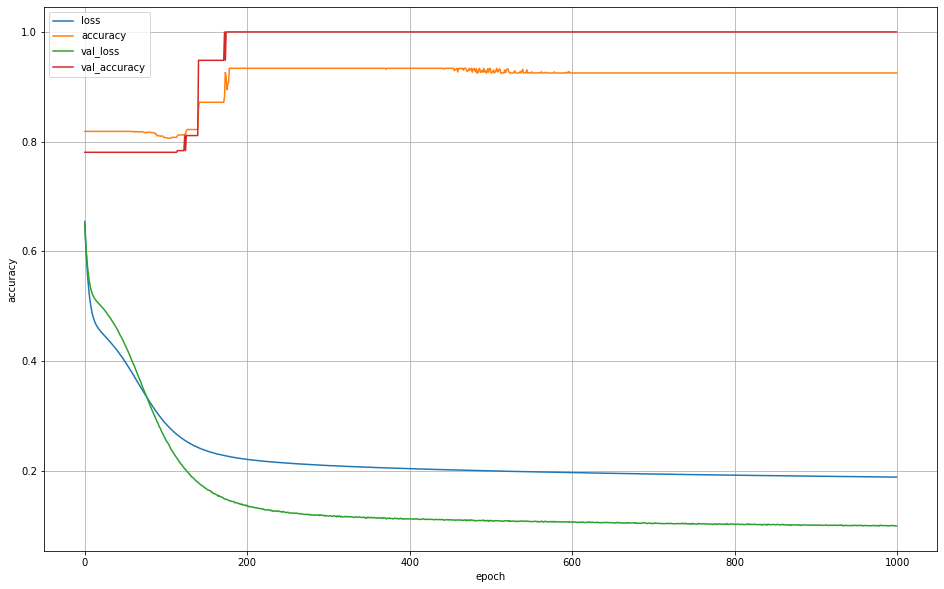

In [86]:
# model
input = k.Input(shape=(timesteps,1))
# input = k.Input(shape=(None,timesteps))

# x = k.layers.LSTM(128, activation="sigmoid", dropout=0.2, recurrent_dropout=0.2)(input)
x = k.layers.Dense(3, activation="sigmoid")(input)
# x = k.layers.Dense(12, activation="sigmoid")(x)
# x = k.layers.Dense(9, activation="sigmoid")(x)
# x = k.layers.Dense(16, activation="sigmoid")(x)
# x = k.layers.Dense(8, activation="sigmoid")(x)

output = k.layers.Dense(1, activation="sigmoid")(x)

model = k.Model(input, output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit
log_path = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="loss", patience=10, mode="min", verbose=1)

history = model.fit(train_data, train_label, validation_split=0.1, epochs=1000, verbose=0, callbacks=[es]) # callbacks=[es, tensorboard_callback])
print(history)
# plot
pd.DataFrame(history.history).plot(figsize=(16,10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()

In [87]:
# evauate
test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)
print(f'test_loss: {test_loss} test_accuracy: {test_acc}')

52/52 - 0s - loss: 0.3290 - accuracy: 0.7967
test_loss: 0.32904189825057983 test_accuracy: 0.7966932058334351


In [99]:
def runit(model, inp):
    inp = np.array(inp)
    pred = model.predict(inp)
    return pred
    
print(runit(model, [0.0, 0.4]))

[[[5.6179334e-07]]

 [[7.4369192e-01]]]


In [33]:
category_names = ["on", "off", "Nan"]
classes = list(range(len(category_names)))
########## CM ##########
predict = model.predict(test_data)
# predicted = np.argmax(predict, axis=1)

draw_CM(test_label, predict)

########## ROC, AUC ##########
x = label_binarize(predict, classes=classes)
y = label_binarize(test_label, classes=classes)

draw_ROC_AUC(x, y, category_names)

InvalidArgumentError: Dimensions [0,2) of indices[shape=[1224,2,3]] must match dimensions [0,2) of updates[shape=[1224,3]] [Op:ScatterNd]

## 6. save model & load model

In [ ]:
model_name =  "model/model_" + dt.now().strftime("%Y%m%d-%H%M%S")
model_format = ".h5"
save_name = model_name + model_format
model.save(save_name)

In [20]:
# launch tensorboard @ localhost:6006
%tensorboard --logdir logs/ --host localhost --port 6006

Reusing TensorBoard on port 6006 (pid 498939), started 17:16:40 ago. (Use '!kill 498939' to kill it.)